Jupyter Notebook, Step 2 - Identify Features
- Build feature selection pipelines using at least three different techniques
- **NOTE**: these pipelines are being used for feature selection not prediction

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest,f_classif,SelectFromModel,SelectPercentile

from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from scipy.stats import boxcox
from tqdm import tqdm

%matplotlib inline

In [126]:
class Read_pickled_madelon_Datasets(object):
   
    # Initializing object.
    def __init__(self):
       
        # Read pickled data from NB1.
        self.data_dir = '../data/dataNB1/'    

        self.read_all_data_from_files()
        
    def read_all_data_from_files(self):
        self.X_train_data_df_1 = pd.read_pickle(self.data_dir +'X_train_data_df_1.p')
        self.X_train_data_df_2 = pd.read_pickle(self.data_dir +'X_train_data_df_2.p')
        self.X_train_data_df_3 = pd.read_pickle(self.data_dir +'X_train_data_df_3.p')

        
        self.y_train_data_1 = pd.read_pickle(self.data_dir + 'y_train_data_1.p')
        self.y_train_data_2 = pd.read_pickle(self.data_dir + 'y_train_data_2.p')
        self.y_train_data_3 = pd.read_pickle(self.data_dir + 'y_train_data_3.p')
        
        self.y_valid_data = pd.read_pickle(self.data_dir + 'y_valid_data.p')
        
    def get_X_train_data_sets(self):
        return(self.X_train_data_df_1, self.X_train_data_df_2, self.X_train_data_df_3)
    
    def get_X_valid_data(self):
        return(self.X_valid_data_df)
    

    def get_X_test_data(self):
        return(self.X_test_data_df)
       
    def get_y_train_data(self):        
        # y data should be a 1D array of labels. It is now read as a dataframe of 1 column with each
        # element as a list of one int.  We want it to be just an int not a list.
        self.y_train_data_1 = np.array([val[0] for val in self.y_train_data_1.values])
        self.y_train_data_2 = np.array([val[0] for val in self.y_train_data_2.values])
        self.y_train_data_3 = np.array([val[0] for val in self.y_train_data_3.values])
        
        return(self.y_train_data_1, self.y_train_data_2, self.y_train_data_3)

    def get_y_valid_data(self):        
        # y data should be a 1D array of labels. It is now read as a dataframe of 1 column with each
        # element as a list of one int.  We want it to be just an int not a list.
        self.y_valid_data_1 = np.array([val[0] for val in self.y_valid_data_1.values])

   

In [127]:
# Read in UCI Madelon Data. For this notebook we only need the X and y train data.
read_data = Read_pickled_madelon_Datasets()

In [128]:
# Read pickled X train data subsets, from Notebook1.
X_train_data_df_1, X_train_data_df_2, X_train_data_df_3 = read_data.get_X_train_data_sets()

# Read pickled y train data subsets, from Notebook1.                                                        
y_train_data_1, y_train_data_2, y_train_data_3 = read_data.get_y_train_data()

# Create a list of X train subsets.
X_train_subsets = [X_train_data_df_1, X_train_data_df_2, X_train_data_df_3]

# Create a list of y train subsets.
y_train_subsets = [y_train_data_1, y_train_data_2, y_train_data_3]


In [92]:
# Read pickled DT regressor (Josh's method) results, since it takes so long to run.
DT_feature_Subsets_Results_df = []
   
DT_feature_Subsets_Results_df.append(pd.read_pickle('../data/dataNB2/DT_NE_feature_Results_TS1_df.p'))
DT_feature_Subsets_Results_df.append(pd.read_pickle('../data/dataNB2/DT_NE_feature_Results_TS2_df.p'))
DT_feature_Subsets_Results_df.append(pd.read_pickle('../data/dataNB2/DT_NE_feature_Results_TS3_df.p'))

In [5]:
rows_training_data = X_train_data_df_1.shape[0]
cols_training_data = X_train_data_df_1.shape[1]
rows_training_data, cols_training_data

(200, 500)

In [6]:
X_train_subsets[0].shape, X_train_subsets[1].shape, X_train_subsets[2].shape,

((200, 500), (200, 500), (200, 500))

In [93]:
def write_SKB_best_features_to_DF(skb, model_name, data_set_name, k):
    # Store results for this feature selection model in a list of dicts.
    dictlst_SKB_Results=[]

    # Get the k features selected.
    skb_feats = np.where(skb.get_support())[0]

    # p-values for the k best features selected.
    skb_pvals_for_best_K = [skb.pvalues_[ind] for ind in skb_feats]

    for ind in range(k):

            entry = {
                    'feat_select_model':  model_name,
                    'train_set'        :  data_set_name,
                    'feature'          :  skb_feats[ind],
                    'p_values'         :  skb_pvals_for_best_K[ind]            
            }

            dictlst_SKB_Results.append(entry)
            
    # Return a dataframe of results.
    return(pd.DataFrame(dictlst_SKB_Results))

In [94]:
def write_SFM_best_features_to_DF(sfm_feat_lst, model_name, data_set_name, num_feats):

    # Store results for this feature selection model in a list of dicts.
    dictlst_SFM_Results=[]

    # Get the features selected.
    sfm_feats = sfm_feat_lst

    for ind in range(num_feats):

            entry = {
                    'feat_select_model':  model_name,
                    'train_set'        :  data_set_name,
                    'feature'          :  sfm_feats[ind],           
                    }

            dictlst_SFM_Results.append(entry)
            
    # Return a dataframe of results.
    return(pd.DataFrame(dictlst_SFM_Results))

In [95]:
# Store results for SelectPercentile. Pass in the SelectPercentile object.
def write_SP_best_features_to_DF(selectperc, method_name, data_set_name, percent):

    dictlst_SP_Results=[]
    
    #top specified features.
    perc = selectperc.percentile   
    tot_feats = len(selectperc.pvalues_)
    num_feats_selected = int((perc/100)*tot_feats)

    # Get the top specified percentile seleted features.
    sp_feats = np.where(selectperc.get_support())[0]

    # p-values for the best features selected.
    sp_pvals_for_best_perc = [selectperc.pvalues_[ind] for ind in sp_feats]

    for ind in range(num_feats_selected):

            entry = {
                    'feat_select_model':  method_name,
                    'train_set'        :  data_set_name,
                    'percentile'       :  str(percent),
                    'feature'          :  sp_feats[ind],
                    'p_values'         :  sp_pvals_for_best_perc[ind]            
            }

            dictlst_SP_Results.append(entry)
    
    # Return a dataframe with the results.
    return (pd.DataFrame(dictlst_SP_Results))

In [96]:
def write_NE_best_features_to_DF(feature_r2_score_list, model_name, data_set_name):

    # Store results for this feature selection model in a list of dicts.
    dictlst_DT_Results_TS1=[]
    
    for ind, val in enumerate(feature_r2_score_list):

        if (val > 0):
            entry = {
                    'Noise_elim_model' : model_name,
                    'train_set'        : data_set_name,
                    'feature'          : ind,
                    'r2_score'         : val            
            }

            dictlst_DT_Results_TS1.append(entry)
        
    # return a dataframe of results.
    return (pd.DataFrame(dictlst_DT_Results_TS1))

In [97]:
# Plotting p-values for SelectKBest and SelectPercentile methods.
def plot_pvalues(df_in, num_selected_feats, title_str):

    # Sort input dataframe according to 'p_values'. 
    # We are interested in low p_value features.    
    df = df_in.sort_values(by = 'p_values')
    
    # Plot num_selected_feats passed in so if the df has more than that, 
    # just plot top num_selected_feats, with lowest p-value.
    pvals = list(df['p_values'][:num_selected_feats])
    features = list(df['feature'][:num_selected_feats])

    plt.figure(figsize=(6,6))
    plt.barh(range(len(pvals)), pvals, label = 'ANOVA F-Test P-Value')

    plt.yticks(range(len(features)), features)
    plt.ylabel('Features', fontsize=12)
    plt.xlabel('ANOVA F-Test P-Value')
    plt.title(title_str, fontsize = 14)

    # Plot p-value = 0.05, optimal p-value.
    plt.axvline(.05, c='g', ls='--', label = 'p-val=0.05')

    plt.legend()
    plt.tight_layout()
    
    # Save file in '../data/imgNB2/'
    plt.savefig(('../data/imgNB2/' + title_str.replace(' ', '_') + '.png'))
    
    plt.show()

In [98]:
# Plot correlation heat map.
def plot_corr(corr, title_str, file_name):

    #corr = X_train_subsets[2].ix[:,feats_selected20].corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask, 1)] = True
    plt.figure(figsize=(15,10))
    with sns.axes_style("white"):
        ax = sns.heatmap(corr, mask=mask, square=True, annot=True,
                         cmap='RdBu', fmt='+.3f')
        plt.xticks(rotation=45, ha='center')
    plt.title(title_str)
    # Save file in data/imgNB2/
    plt.savefig(file_name)
    plt.show()

In [99]:
# Plotting R2 scores for DecisionTreeRegressor and KNeighborsRegressor sfm methods.
def plot_R2_scores(df_input, title_str):
    
    # Bar plot for KNN top features, R2>0, with sorted R2 values.
    df_sort_R2 = df_input.sort_values(by ='r2_score')
    df_sort_R2.r2_score.plot(kind = 'barh', fontsize = 14, figsize=(8,7), width = 0.5) 

    plt.title(title_str, fontsize = 14)
    plt.yticks(range(len(df_sort_R2.feature)), df_sort_R2.feature)
    plt.xlabel('R2 scores', fontsize = 12); plt.ylabel('features', fontsize = 12)
    plt.tight_layout()
    
    # Save file in data/imgNB2/
    plt.savefig(('../data/imgNB2/' + title_str.replace(' ', '_') + '.png'))
    
    plt.show()

In [100]:
#**********************************************************************
# NOISE ELIMINATION: Perform Regression on predictors to eliminate 
#                    noisy ones.
#                    
# We are going to do this by setting each predictor to become a target 
# and then fit a regression model with the other predictors to see if 
# there is any relationship between a predictor and the rest of the 
# predictors.

# X is continuous data, that's why this feature evaluation becomes a
# regression problem. We can try diffrent regressors. 
#**********************************************************************

In [101]:
def calculate_r_2_for_feature(X, X_column, model):
    tmp_X = X.drop(X_column, axis=1)
    tmp_y = X[X_column]

    tmp_X_train, tmp_X_test, tmp_y_train, tmp_y_test =  \
                                train_test_split(tmp_X,tmp_y,test_size=0.25)                                                                   

    # We pass in the model so we can test various regressors.
    regressor = model()
    regressor.fit(tmp_X_train, tmp_y_train)

    score = regressor.score(tmp_X_test, tmp_y_test)
    return score

In [102]:
# This method is calling the calculate_r_2_for_feature 10 times and 
# taking the avg of their r2 scores.
def mean_r2_for_feature(X, X_column, model, runs = 10):
    scores = []
    for _ in range(runs):
        scores.append(calculate_r_2_for_feature(X, X_column, model))
        
    scores = np.array(scores)
    return scores.mean()

In [29]:
#***********************************************************
# NOISE ELIMINATION METHOD 1: DecisionTreeRegressor                                    
#
# For each feature, we will drop it from the rest of the
# predictors and predict on it with this model. This will
# tell us how related is this feature to the others in the
# group.
#***********************************************************
DT_mean_R2scores_subsets = []
num_features = len(X_train_subsets[0].columns)
for X_subset in X_train_subsets:
    
    DT_mean_R2scores = []
    for i in tqdm(range(num_features)):
        score = mean_r2_for_feature(X_subset, i, DecisionTreeRegressor)
        DT_mean_R2scores.append(score)
        
    DT_mean_R2scores_subsets.append(DT_mean_R2scores)

100%|██████████| 500/500 [03:02<00:00,  2.73it/s]


In [30]:
# Write results for all training sets. Create a list of output dataframes for DT results
# for each subset of X train data.
DT_feature_Subsets_Results_df = []
cnt=0
for subset_scores in DT_mean_R2scores_subsets: 
    cnt+=1
    df = write_NE_best_features_to_DF(subset_scores, 'DecisionTreeRegressor', 'train_data_df_'+str(cnt))
    DT_feature_Subsets_Results_df.append(df)

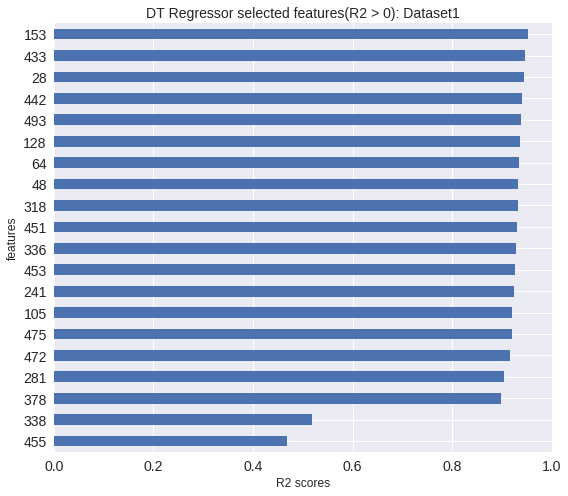

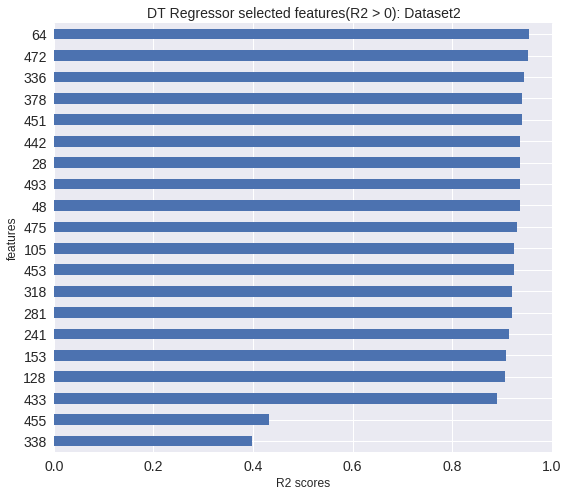

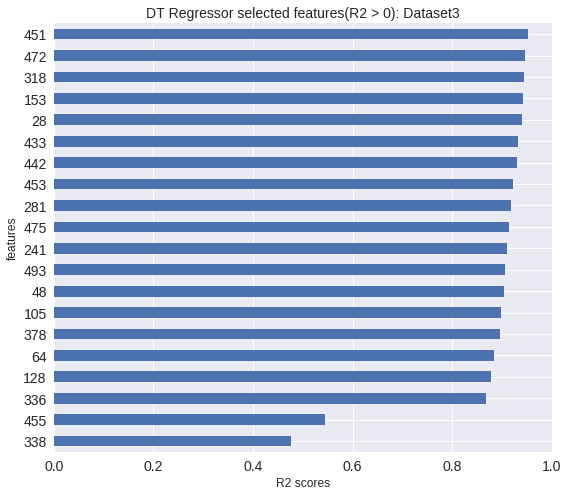

In [43]:
# Plot R2 scores for DT regressor selected features.
for i in range(3):
    plot_R2_scores(DT_feature_Subsets_Results_df[i], 'DT Regressor selected features(R2 > 0): Dataset'+str(i+1))

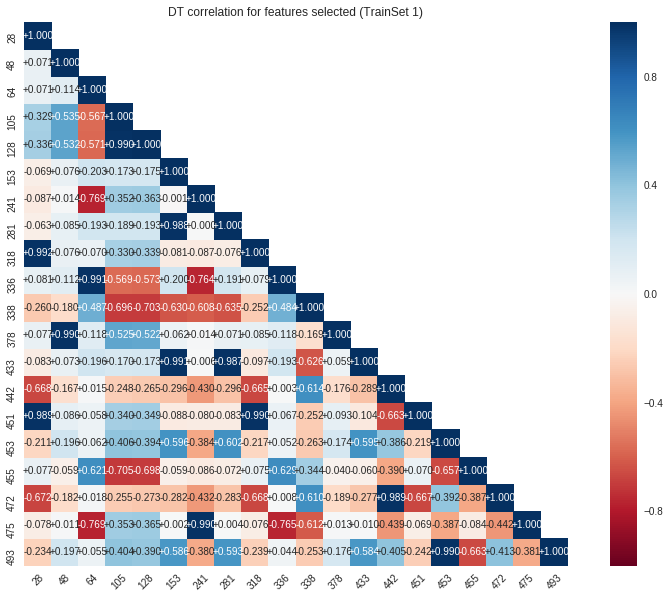

In [52]:
# Plot correlation for dataset 1 features selected.
feats_selected = DT_feature_Subsets_Results_df[0]['feature']
corr = X_train_subsets[0].ix[:,feats_selected].corr()
plot_corr(corr, 'DT correlation for features selected (TrainSet 1)', 
          '../data/imgNB2/SKB_corr_img_TS1')

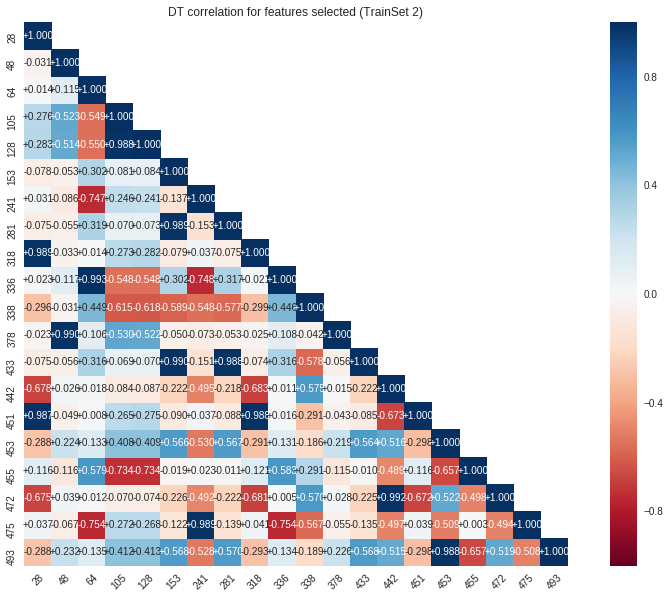

In [51]:
# Plot correlation for dataset 2 features selected.
feats_selected = DT_feature_Subsets_Results_df[1]['feature']
corr = X_train_subsets[1].ix[:,feats_selected].corr()
plot_corr(corr, 'DT correlation for features selected (TrainSet 2)', 
          '../data/imgNB2/SKB_corr_img_TS2')

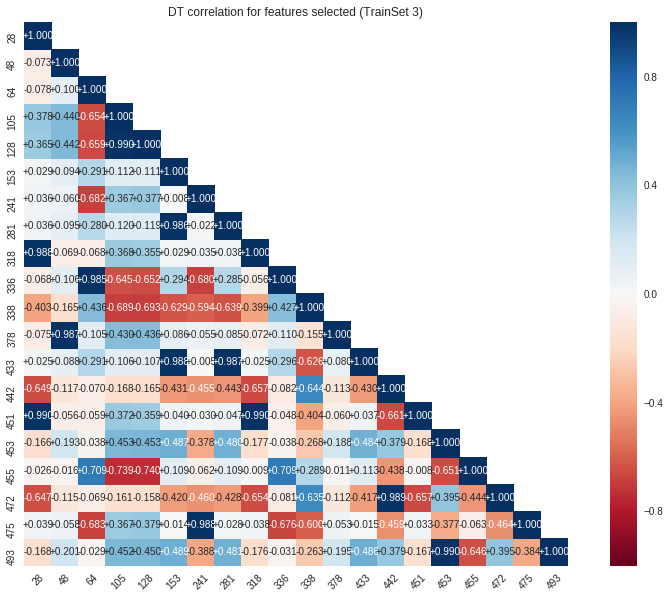

In [50]:
# Plot correlation for dataset 3 features selected.
feats_selected = DT_feature_Subsets_Results_df[2]['feature']
corr = X_train_subsets[2].ix[:,feats_selected].corr()
plot_corr(corr, 'DT correlation for features selected (TrainSet 3)', 
          '../data/imgNB2/SKB_corr_img_TS3')

In [53]:
#******************************************************************************
# FEATURE SELECTION METHOD: Use SelectKBest to find the 20 best features.
#                           Since we know that in this dataset there are 
#                           20 good features, 5 redundant and 15 redundant.
#
# We do this by setting K = 20 and since madelon is a classification 
# dataset, we set score_func = f_classif
#
# We are selecting 20 features since that is the number of features we got
# above. We can fine tume these later, by varying K and C to get the 
# optimal number of predictors. 
#
# From the madelon description it seems like there are 5 informative features.
#
# This method uses the f-test where:
#  pvalues_: Returns an array of ANOVA F-Test pvalues, against the null 
#  hypothesis that the values (rows) in that feature are different from each other.
#*******************************************************************************

In [103]:
# Zip the X_train_subsets, with the y_trains so we can loop through all subsets.
Xy_data_list = zip(X_train_subsets, y_train_subsets)
cnt=0
SKB_Results_for_all_sets_df = []
for X_subset, y_subset in Xy_data_list:
 
    cnt +=1
    
    # Inst. SS, transform and scale data. 
    scaler = StandardScaler()
    X_subset_scaled = scaler.fit_transform(X_subset)

    # Initialize and fit SKB. 
    skb = SelectKBest(k=20, score_func=f_classif) 
    skb.fit(X_subset_scaled, y_subset)

    # Top 20 features selected.
    SKB_features = np.where(skb.get_support())[0]


    SKB_Results_df = write_SKB_best_features_to_DF(skb, 'SelectKBest', 'DataSet_'+str(cnt), k=20)
    
    # Save SKB results for each training dataset.
    SKB_Results_for_all_sets_df.append(SKB_Results_df)
    
    

In [104]:
SKB_Results_for_all_sets_df[0], SKB_Results_for_all_sets_df[1], SKB_Results_for_all_sets_df[2]

(   feat_select_model  feature  p_values  train_set
 0        SelectKBest       17  0.028438  DataSet_1
 1        SelectKBest       32  0.024135  DataSet_1
 2        SelectKBest       55  0.016362  DataSet_1
 3        SelectKBest       64  0.001131  DataSet_1
 4        SelectKBest       66  0.021778  DataSet_1
 5        SelectKBest       79  0.002328  DataSet_1
 6        SelectKBest      120  0.018693  DataSet_1
 7        SelectKBest      213  0.025809  DataSet_1
 8        SelectKBest      241  0.000013  DataSet_1
 9        SelectKBest      286  0.008664  DataSet_1
 10       SelectKBest      296  0.003826  DataSet_1
 11       SelectKBest      335  0.001918  DataSet_1
 12       SelectKBest      336  0.000556  DataSet_1
 13       SelectKBest      338  0.016394  DataSet_1
 14       SelectKBest      357  0.014814  DataSet_1
 15       SelectKBest      379  0.008907  DataSet_1
 16       SelectKBest      390  0.000499  DataSet_1
 17       SelectKBest      430  0.016325  DataSet_1
 18       Se

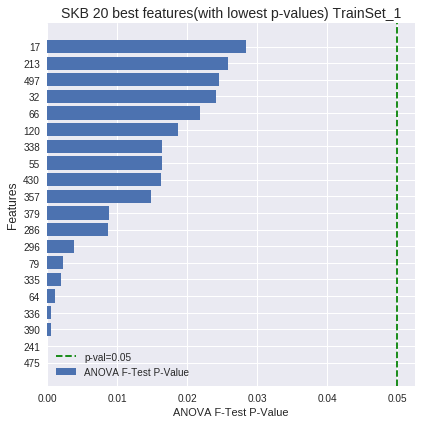

In [105]:
plot_pvalues(SKB_Results_for_all_sets_df[0], 20, 'SKB 20 best features(with lowest p-values) TrainSet_'+str(1))

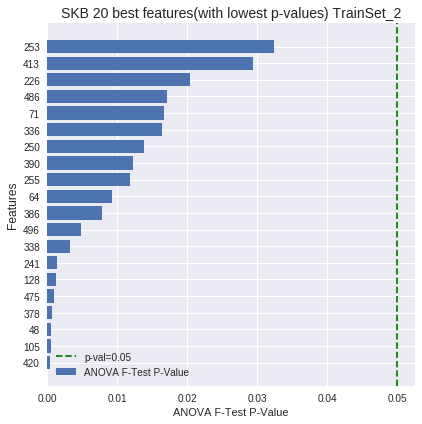

In [106]:
plot_pvalues(SKB_Results_for_all_sets_df[1], 20, 'SKB 20 best features(with lowest p-values) TrainSet_'+str(2))

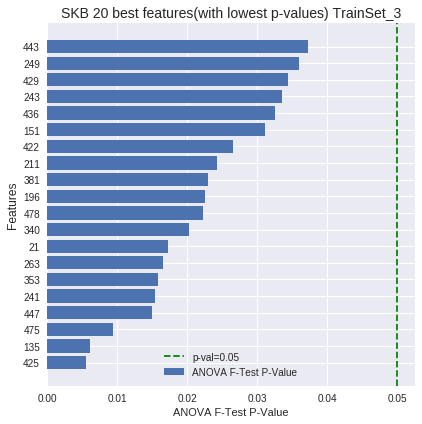

In [107]:
plot_pvalues(SKB_Results_for_all_sets_df[2], 20, 'SKB 20 best features(with lowest p-values) TrainSet_'+str(3))

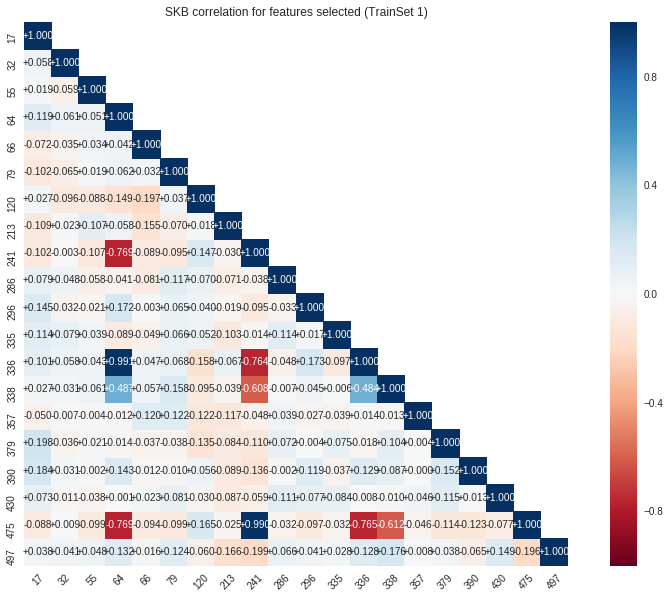

In [108]:
# Plot correlation for dataset 1 features selected.
feats_selected = SKB_Results_for_all_sets_df[0]['feature']
corr = X_train_subsets[0].ix[:,feats_selected].corr()
plot_corr(corr, 'SKB correlation for features selected (TrainSet 1)', 
          '../data/imgNB2/SKB_corr_img_TS1')

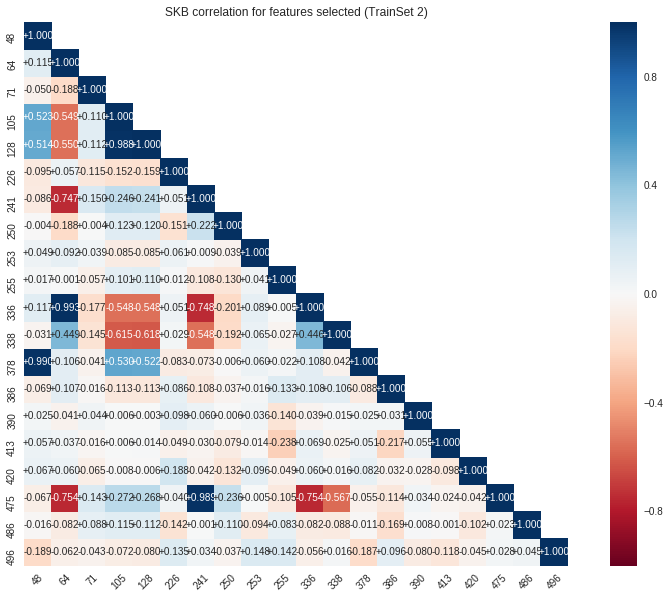

In [109]:
# Plot correlation for dataset 1 features selected.
feats_selected = SKB_Results_for_all_sets_df[1]['feature']
corr = X_train_subsets[1].ix[:,feats_selected].corr()
plot_corr(corr, 'SKB correlation for features selected (TrainSet 2)', 
          '../data/imgNB2/SKB_corr_img_TS2')

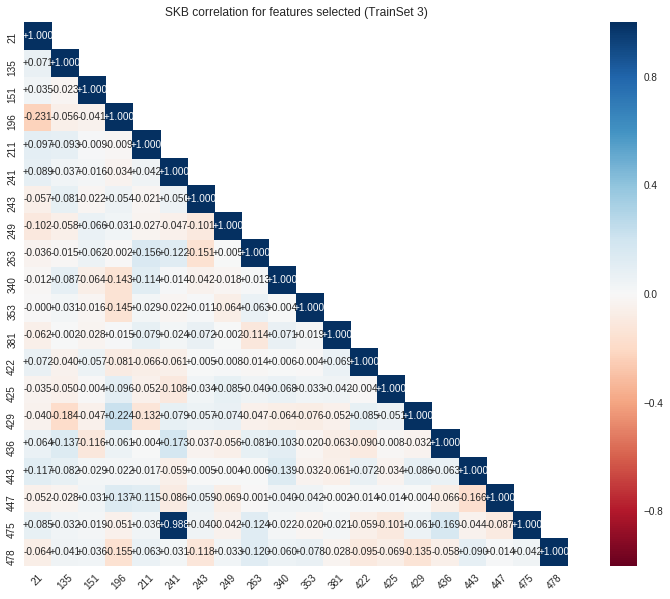

In [110]:
# Plot correlation for dataset 3 features selected.
feats_selected = SKB_Results_for_all_sets_df[2]['feature']
corr = X_train_subsets[2].ix[:,feats_selected].corr()
plot_corr(corr, 'SKB correlation for features selected (TrainSet 3)', 
          '../data/imgNB2/SKB_corr_img_TS3')

In [62]:
#*************************************************************************
# FEATURE SELECTION: Use Select Percentile to find the 4% best features.
#                    Since we have 500, 4% is 20, we know 20 are good.
#
# This method works almost the exact same as SelectKBest, but instead 
# of selecting how many columns you want, you select the percentile. 
# Below, we take the top 4% of columns (i.e. in the top 4% of pvalues). 
# 
#*************************************************************************

In [111]:
# Zip the X_train_subsets, with the y_trains so we can loop through all subsets.
Xy_data_list = zip(X_train_subsets, y_train_subsets)
cnt=0
SP_Results_for_all_sets_df = []
for X_subset, y_subset in Xy_data_list:
 
    cnt +=1

    # Inst. SS, transform and scale data. 
    scaler = StandardScaler()
    X_subset_scaled = scaler.fit_transform(X_subset)

    # Top p-values.
    selectperc = SelectPercentile(percentile=4)

    # Note he is passing in a scaled version of X_train here.
    selectperc.fit(X_subset_scaled, y_subset)
    
    # Features selected.
    sp_features = np.where(selectperc.get_support())[0]

    # Let's look at the ANOVA F-test p-values.
    SP_Results_df = write_SP_best_features_to_DF(selectperc, 'SelectPercentile', 'DataSet_'+str(cnt), percent=4)
    
    # Save SP resuts for each training dataset.
    SP_Results_for_all_sets_df.append(SP_Results_df)

In [112]:
SP_Results_for_all_sets_df[0], SP_Results_for_all_sets_df[1], SP_Results_for_all_sets_df[2]

(   feat_select_model  feature  p_values percentile  train_set
 0   SelectPercentile       17  0.028438          4  DataSet_1
 1   SelectPercentile       32  0.024135          4  DataSet_1
 2   SelectPercentile       55  0.016362          4  DataSet_1
 3   SelectPercentile       64  0.001131          4  DataSet_1
 4   SelectPercentile       66  0.021778          4  DataSet_1
 5   SelectPercentile       79  0.002328          4  DataSet_1
 6   SelectPercentile      120  0.018693          4  DataSet_1
 7   SelectPercentile      213  0.025809          4  DataSet_1
 8   SelectPercentile      241  0.000013          4  DataSet_1
 9   SelectPercentile      286  0.008664          4  DataSet_1
 10  SelectPercentile      296  0.003826          4  DataSet_1
 11  SelectPercentile      335  0.001918          4  DataSet_1
 12  SelectPercentile      336  0.000556          4  DataSet_1
 13  SelectPercentile      338  0.016394          4  DataSet_1
 14  SelectPercentile      357  0.014814          4  Da

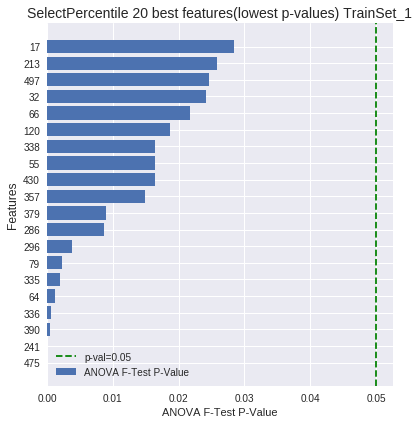

In [113]:
plot_pvalues(SP_Results_for_all_sets_df[0], 20, 'SelectPercentile 20 best features(lowest p-values) TrainSet_'+str(1))

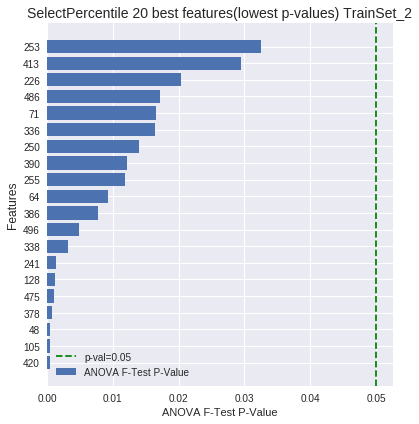

In [114]:
plot_pvalues(SP_Results_for_all_sets_df[1], 20, 'SelectPercentile 20 best features(lowest p-values) TrainSet_'+str(2))

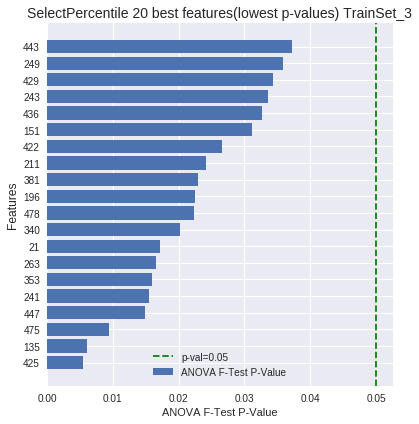

In [115]:
plot_pvalues(SP_Results_for_all_sets_df[2], 20, 'SelectPercentile 20 best features(lowest p-values) TrainSet_'+str(3))

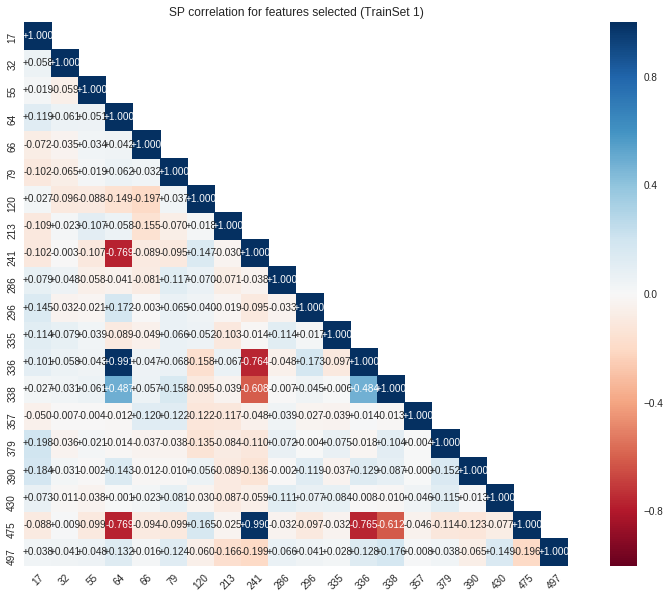

In [116]:
# Plot correlation for dataset 1 features selected.
feats_selected = SP_Results_for_all_sets_df[0]['feature']
corr = X_train_subsets[0].ix[:,feats_selected].corr()
plot_corr(corr, 'SP correlation for features selected (TrainSet 1)', 
          '../data/imgNB2/SP_corr_img_TS1')

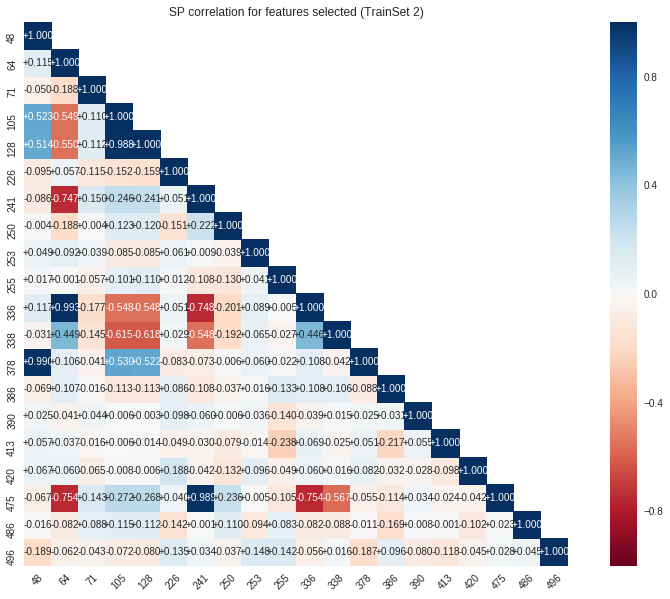

In [117]:
# Plot correlation for dataset 2 features selected.
feats_selected = SP_Results_for_all_sets_df[1]['feature']
corr = X_train_subsets[1].ix[:,feats_selected].corr()
plot_corr(corr, 'SP correlation for features selected (TrainSet 2)', 
          '../data/imgNB2/SP_corr_img_TS2')

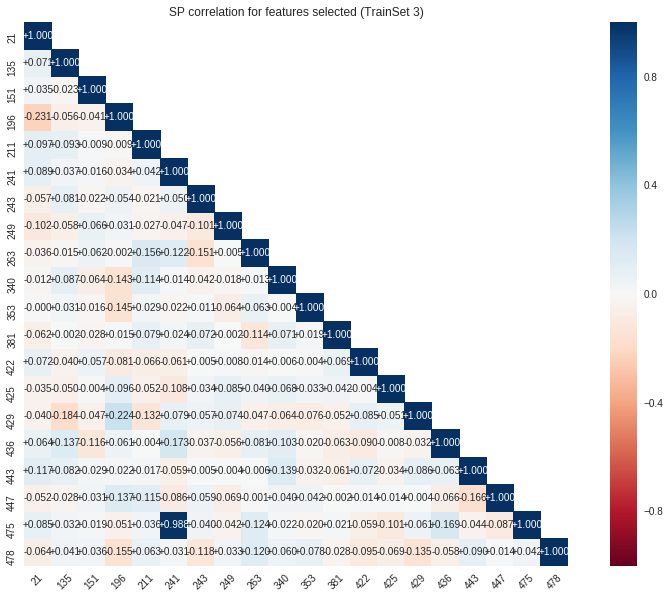

In [118]:
# Plot correlation for dataset 3 features selected.
feats_selected = SP_Results_for_all_sets_df[2]['feature']
corr = X_train_subsets[2].ix[:,feats_selected].corr()
plot_corr(corr, 'SP correlation for features selected (TrainSet 3)', 
          '../data/imgNB2/SP_corr_img_TS3')

In [71]:
#*************************************************************************
# FEATURE SELECTION: Use Select from model Lasso 
#*************************************************************************

In [119]:
# Zip the X_train_subsets, with the y_trains so we can loop through all subsets.
Xy_data_list = zip(X_train_subsets, y_train_subsets)
cnt=0
SFMlasso_Results_for_all_sets_df = []
for X_subset, y_subset in Xy_data_list:
 
    cnt +=1

    # Inst. SS, transform and scale data. 
    scaler = StandardScaler()
    X_subset_scaled = scaler.fit_transform(X_subset)

    # I am using Lasso as the base estimator 
    # since the L1 norm promotes sparsity of features.
    sfm_lasso = SelectFromModel(Lasso(alpha=0.13))

    # Note he is passing in a scaled version of X_train here.
    sfm_lasso.fit(X_subset_scaled, y_subset)
    sfm_lasso.transform(X_subset_scaled)
    
    # features selected.
    sfm_lasso_feats = np.where(sfm_lasso.get_support())[0]
    
    # Count of features selected.
    lasso_feat_count = len(sfm_lasso_feats)

    # Let's write the results to a dataframe.
    SFMlasso_Results_df = write_SFM_best_features_to_DF(sfm_lasso_feats, 'SFM_Lasso', 
                                                        'DataSet_'+str(cnt), 
                                                        num_feats= lasso_feat_count)
    
    # Save SFM Lasso resuts for each training dataset.
    SFMlasso_Results_for_all_sets_df.append(SFMlasso_Results_df)

In [120]:
SFMlasso_Results_for_all_sets_df[0], SFMlasso_Results_for_all_sets_df[1], SFMlasso_Results_for_all_sets_df[2]

(   feat_select_model  feature  train_set
 0          SFM_Lasso       32  DataSet_1
 1          SFM_Lasso       55  DataSet_1
 2          SFM_Lasso       66  DataSet_1
 3          SFM_Lasso       79  DataSet_1
 4          SFM_Lasso       99  DataSet_1
 5          SFM_Lasso      110  DataSet_1
 6          SFM_Lasso      120  DataSet_1
 7          SFM_Lasso      138  DataSet_1
 8          SFM_Lasso      178  DataSet_1
 9          SFM_Lasso      213  DataSet_1
 10         SFM_Lasso      236  DataSet_1
 11         SFM_Lasso      286  DataSet_1
 12         SFM_Lasso      296  DataSet_1
 13         SFM_Lasso      326  DataSet_1
 14         SFM_Lasso      335  DataSet_1
 15         SFM_Lasso      347  DataSet_1
 16         SFM_Lasso      357  DataSet_1
 17         SFM_Lasso      379  DataSet_1
 18         SFM_Lasso      390  DataSet_1
 19         SFM_Lasso      430  DataSet_1
 20         SFM_Lasso      475  DataSet_1,
    feat_select_model  feature  train_set
 0          SFM_Lasso       48  D

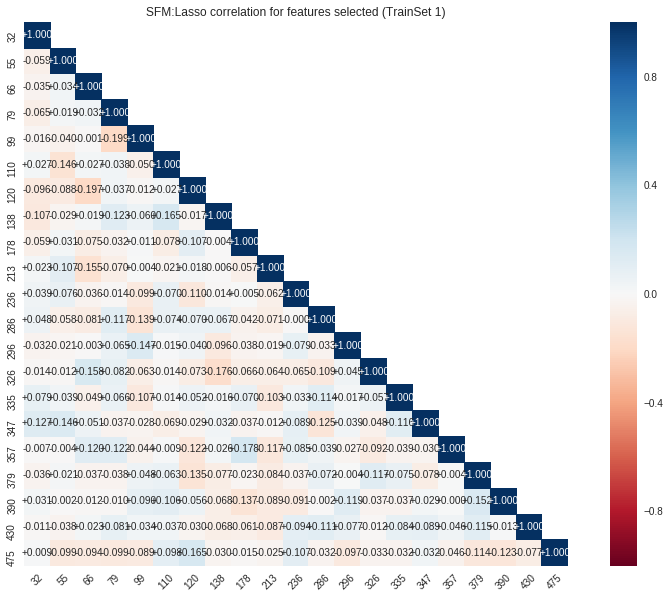

In [121]:
# Plot correlation for dataset 1 features selected.
feats_selected = SFMlasso_Results_for_all_sets_df[0]['feature']
corr = X_train_subsets[0].ix[:,feats_selected].corr()
plot_corr(corr, 'SFM:Lasso correlation for features selected (TrainSet 1)', 
          '../data/imgNB2/SFM_Lasso_corr_img_TS1')

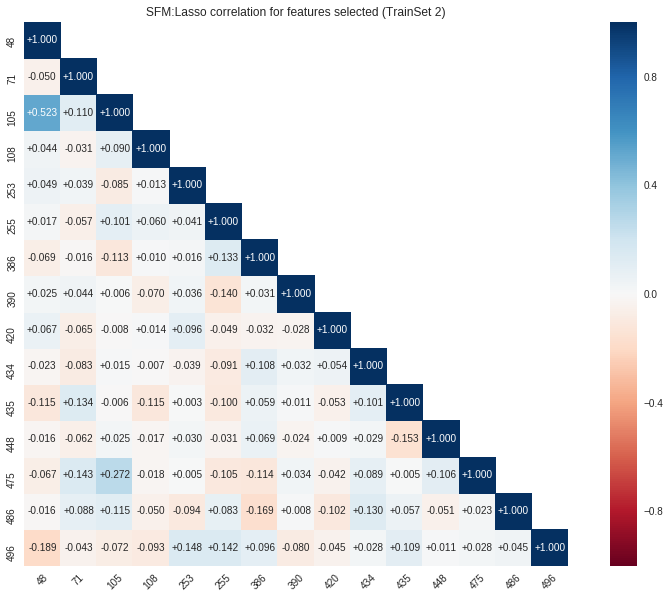

In [122]:
# Plot correlation for dataset 2 features selected.
feats_selected = SFMlasso_Results_for_all_sets_df[1]['feature']
corr = X_train_subsets[1].ix[:,feats_selected].corr()
plot_corr(corr, 'SFM:Lasso correlation for features selected (TrainSet 2)', 
          '../data/imgNB2/SFM_Lasso_corr_img_TS2')

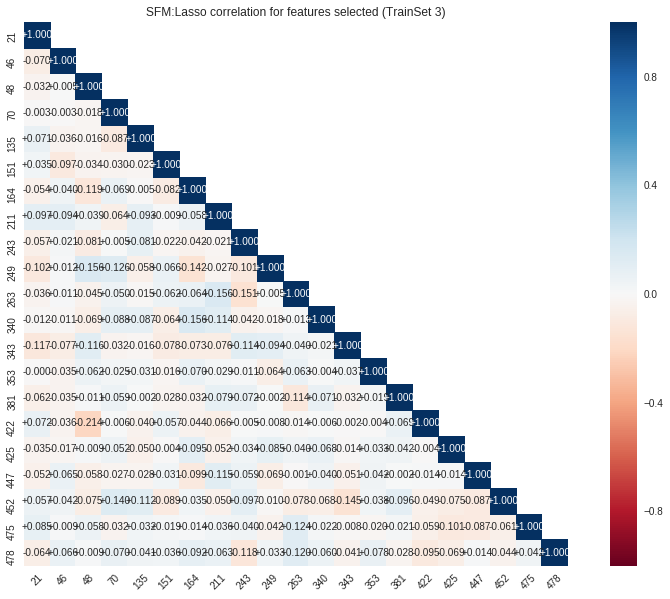

In [123]:
#Plot correlation for dataset 3 features selected.
feats_selected = SFMlasso_Results_for_all_sets_df[2]['feature']
corr = X_train_subsets[2].ix[:,feats_selected].corr()
plot_corr(corr, 'SFM:Lasso correlation for features selected (TrainSet 3)', 
          '../data/imgNB2/SFM_Lasso_corr_img_TS3')

In [124]:
# Pickle the DataFrames for results from the 3 feature selection methods.

SKB_Results_for_all_sets_df[0].to_pickle('../data/dataNB2/SKB_feature_Results_TS1_df.p')
SP_Results_for_all_sets_df[0].to_pickle('../data/dataNB2/SP_feature_Results_TS1_df.p')
SFMlasso_Results_for_all_sets_df[0].to_pickle('../data/dataNB2/Lasso_feature_Results_TS1_df.p')
DT_feature_Subsets_Results_df[0].to_pickle('../data/dataNB2/DT_NE_feature_Results_TS1_df.p')


SKB_Results_for_all_sets_df[1].to_pickle('../data/dataNB2/SKB_feature_Results_TS2_df.p')
SP_Results_for_all_sets_df[1].to_pickle('../data/dataNB2/SP_feature_Results_TS2_df.p')
SFMlasso_Results_for_all_sets_df[1].to_pickle('../data/dataNB2/Lasso_feature_Results_TS2_df.p')
DT_feature_Subsets_Results_df[1].to_pickle('../data/dataNB2/DT_NE_feature_Results_TS2_df.p')

SKB_Results_for_all_sets_df[2].to_pickle('../data/dataNB2/SKB_feature_Results_TS3_df.p')
SP_Results_for_all_sets_df[2].to_pickle('../data/dataNB2/SP_feature_Results_TS3_df.p')
SFMlasso_Results_for_all_sets_df[2].to_pickle('../data/dataNB2/Lasso_feature_Results_TS3_df.p')
DT_feature_Subsets_Results_df[2].to_pickle('../data/dataNB2/DT_NE_feature_Results_TS3_df.p')